
# Lesson 14 — Expectation Maximization (EM) Algorithm (CS229-style)

This lesson focuses on **unsupervised learning** via:

- **K-means** (hard assignments)
- **Gaussian Mixture Models (GMMs)** (soft assignments)
- **EM algorithm** (E-step / M-step)
- **Log-likelihood** as the objective + convergence plots
- Visualizations that make EM *feel* intuitive:
  - Contours of Gaussian components
  - Responsibility heatmaps (soft clustering)
  - Side-by-side: K-means vs GMM

> **CS229 takeaway:** EM is coordinate ascent on a lower bound of the log-likelihood (via Jensen’s inequality).



## 0) Setup


In [1]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)



## 1) Generate 2D mixture data (ground truth clusters)

We’ll generate a dataset from a true mixture of Gaussians so you can see whether EM recovers the structure.


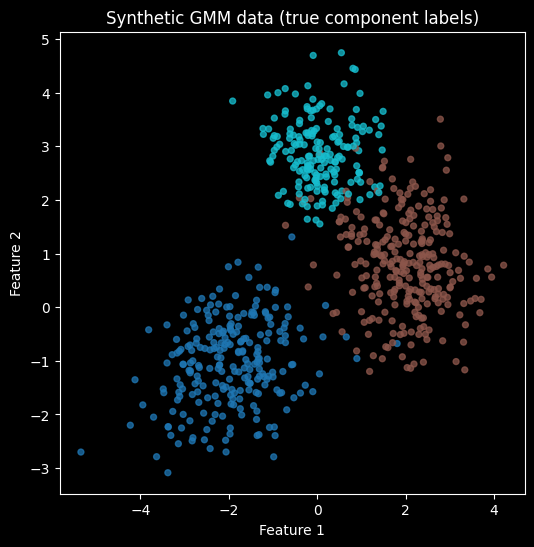

In [2]:

def make_gmm_data(n=600, mus=None, Sigmas=None, pis=None, seed=0):
    rng = np.random.default_rng(seed)
    if mus is None:
        mus = [
            np.array([-2.0, -1.0]),
            np.array([ 2.0,  0.8]),
            np.array([ 0.0,  2.8])
        ]
    if Sigmas is None:
        Sigmas = [
            np.array([[0.9, 0.2],[0.2, 0.6]]),
            np.array([[0.6,-0.1],[-0.1, 0.7]]),
            np.array([[0.5, 0.0],[0.0, 0.4]]),
        ]
    k = len(mus)
    if pis is None:
        pis = np.array([0.35, 0.40, 0.25])

    z = rng.choice(k, size=n, p=pis)
    X = np.zeros((n,2))
    for j in range(k):
        idx = np.where(z == j)[0]
        X[idx] = rng.multivariate_normal(mus[j], Sigmas[j], size=len(idx))
    return X, z, np.array(mus), np.array(Sigmas), np.array(pis)

X, z_true, mus_true, Sigmas_true, pis_true = make_gmm_data(n=700, seed=1)

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=z_true, cmap="tab10", alpha=0.75, s=18)
plt.title("Synthetic GMM data (true component labels)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



## 2) K-means (hard assignments)

K-means alternates:
1. Assign each point to closest centroid
2. Recompute centroids

This is a special case of EM-like alternation, but with **hard** cluster membership.


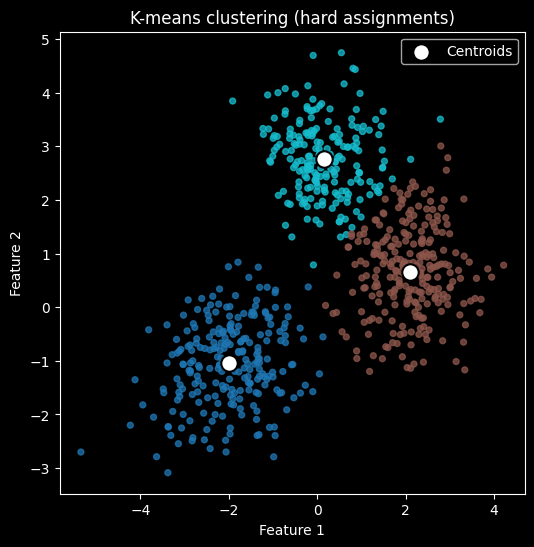

In [3]:

def kmeans(X, k=3, steps=25, seed=0):
    rng = np.random.default_rng(seed)
    n, d = X.shape

    # init centroids by sampling data points
    centroids = X[rng.choice(n, size=k, replace=False)].copy()

    for _ in range(steps):
        # assignment
        # distances: (n,k)
        dist2 = np.sum((X[:,None,:] - centroids[None,:,:])**2, axis=2)
        labels = np.argmin(dist2, axis=1)

        # update
        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            pts = X[labels == j]
            if len(pts) == 0:
                new_centroids[j] = X[rng.integers(0, n)]
            else:
                new_centroids[j] = pts.mean(axis=0)
        centroids = new_centroids

    return labels, centroids

labels_km, C = kmeans(X, k=3, steps=30, seed=2)

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=labels_km, cmap="tab10", alpha=0.75, s=18)
plt.scatter(C[:,0], C[:,1], color="white", s=140, edgecolors="black", linewidths=1.5, label="Centroids")
plt.title("K-means clustering (hard assignments)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="upper right")
plt.show()



## 3) GMM + EM (soft assignments)

A Gaussian mixture model assumes:
\[
p(x) = \sum_{j=1}^k \pi_j \mathcal{N}(x \mid \mu_j, \Sigma_j)
\]

EM alternates:
- **E-step:** compute responsibilities \(r_{ij}\) (soft assignment probabilities)
- **M-step:** update \(\pi_j, \mu_j, \Sigma_j\) using those responsibilities

We’ll implement everything in NumPy.


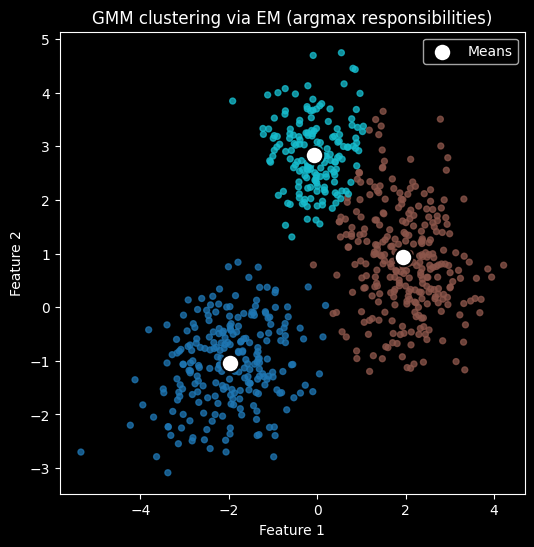

In [4]:

def logsumexp(a, axis=None, keepdims=False):
    amax = np.max(a, axis=axis, keepdims=True)
    out = amax + np.log(np.sum(np.exp(a - amax), axis=axis, keepdims=True))
    if not keepdims:
        out = np.squeeze(out, axis=axis)
    return out

def gaussian_logpdf(X, mu, Sigma):
    # X: (n,d), mu: (d,), Sigma: (d,d)
    d = X.shape[1]
    eps = 1e-6
    Sigma = Sigma + eps*np.eye(d)
    L = np.linalg.cholesky(Sigma)
    # solve for (x-mu) in Sigma^{-1}
    Xm = X - mu
    sol = np.linalg.solve(L, Xm.T)           # (d,n)
    quad = np.sum(sol**2, axis=0)            # (n,)
    logdet = 2*np.sum(np.log(np.diag(L)))    # scalar
    return -0.5*(d*np.log(2*np.pi) + logdet + quad)

def gmm_init(X, k=3, seed=0):
    rng = np.random.default_rng(seed)
    n, d = X.shape
    # init means by sampling points
    mus = X[rng.choice(n, size=k, replace=False)].copy()
    # init covariances to global covariance
    S = np.cov(X.T) + 1e-3*np.eye(d)
    Sigmas = np.array([S.copy() for _ in range(k)])
    pis = np.ones(k) / k
    return pis, mus, Sigmas

def e_step(X, pis, mus, Sigmas):
    n = X.shape[0]
    k = len(pis)
    log_r = np.zeros((n,k))
    for j in range(k):
        log_r[:,j] = np.log(pis[j] + 1e-12) + gaussian_logpdf(X, mus[j], Sigmas[j])
    # normalize
    log_norm = logsumexp(log_r, axis=1, keepdims=True)
    log_resp = log_r - log_norm
    resp = np.exp(log_resp)
    return resp

def m_step(X, resp):
    n, d = X.shape
    k = resp.shape[1]
    Nk = resp.sum(axis=0) + 1e-12
    pis = Nk / n
    mus = (resp.T @ X) / Nk[:,None]
    Sigmas = np.zeros((k,d,d))
    for j in range(k):
        Xm = X - mus[j]
        Sigmas[j] = (resp[:,j][:,None] * Xm).T @ Xm / Nk[j]
        Sigmas[j] += 1e-6*np.eye(d)  # stabilize
    return pis, mus, Sigmas

def gmm_loglik(X, pis, mus, Sigmas):
    n = X.shape[0]
    k = len(pis)
    log_terms = np.zeros((n,k))
    for j in range(k):
        log_terms[:,j] = np.log(pis[j] + 1e-12) + gaussian_logpdf(X, mus[j], Sigmas[j])
    return np.sum(logsumexp(log_terms, axis=1))

def em_gmm(X, k=3, steps=40, seed=0):
    pis, mus, Sigmas = gmm_init(X, k=k, seed=seed)
    ll_hist = []
    for _ in range(steps):
        resp = e_step(X, pis, mus, Sigmas)
        pis, mus, Sigmas = m_step(X, resp)
        ll_hist.append(gmm_loglik(X, pis, mus, Sigmas))
    return pis, mus, Sigmas, resp, np.array(ll_hist)

pis_hat, mus_hat, Sigmas_hat, resp_hat, ll_hist = em_gmm(X, k=3, steps=50, seed=3)

plt.figure(figsize=(7,4))
plt.plot(ll_hist)
plt.xlabel("EM Iteration")
plt.ylabel("Log-likelihood")
plt.title("GMM EM convergence (log-likelihood increases)")
plt.show()

labels_em = np.argmax(resp_hat, axis=1)

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=labels_em, cmap="tab10", alpha=0.75, s=18)
plt.scatter(mus_hat[:,0], mus_hat[:,1], color="white", s=160, edgecolors="black", linewidths=1.5, label="Means")
plt.title("GMM clustering via EM (argmax responsibilities)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="upper right")
plt.show()



## 4) Plot Gaussian contours (CS229-style)

We’ll draw level sets of each learned Gaussian component.

Contours are a clean way to show **elliptical structure** that K-means can’t represent.


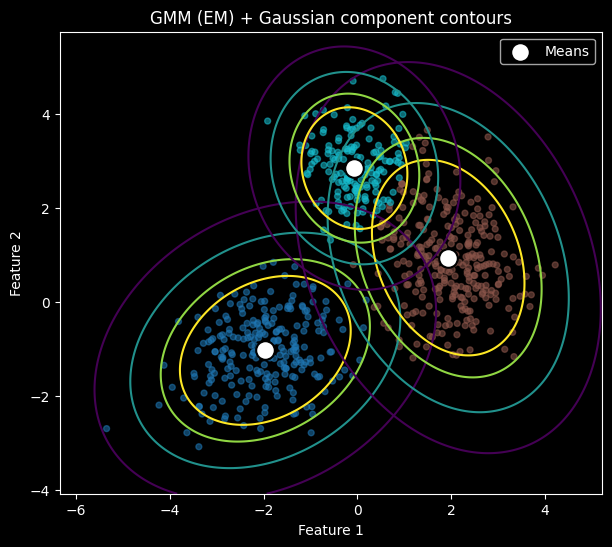

In [5]:

def plot_gmm_contours(X, labels, pis, mus, Sigmas, title):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 350),
        np.linspace(y_min, y_max, 350)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    plt.figure(figsize=(7,6))
    plt.scatter(X[:,0], X[:,1], c=labels, cmap="tab10", alpha=0.55, s=18)

    # contour each component
    for j in range(len(pis)):
        # logpdf for this component only (not mixture)
        Z = gaussian_logpdf(grid, mus[j], Sigmas[j]).reshape(xx.shape)
        # pick contour levels relative to max for readability
        levels = np.max(Z) + np.array([-8, -5, -3, -2])
        plt.contour(xx, yy, Z, levels=levels, linewidths=1.5)

    plt.scatter(mus[:,0], mus[:,1], color="white", s=180, edgecolors="black", linewidths=1.5, label="Means")
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right")
    plt.show()

plot_gmm_contours(X, labels_em, pis_hat, mus_hat, Sigmas_hat, "GMM (EM) + Gaussian component contours")



## 5) Responsibilities heatmap (soft clustering)

Instead of hard cluster labels, EM produces responsibilities \(r_{ij}\) (a distribution over clusters for each point).

We’ll visualize the **mixture’s class-1-like probability** idea from earlier lessons:
here, it’s simply the responsibility of a chosen component.


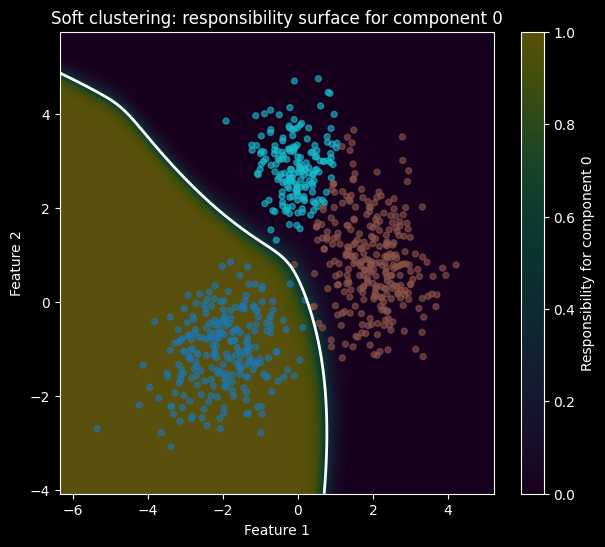

In [6]:

def plot_responsibility_surface(X, resp, comp_index=0, title="Responsibility surface"):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 350),
        np.linspace(y_min, y_max, 350)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Compute responsibilities on the grid using current parameters by re-running e-step
    # (we'll capture pis/mus/Sigmas from outer scope)
    grid_resp = e_step(grid, pis_hat, mus_hat, Sigmas_hat)[:, comp_index].reshape(xx.shape)

    plt.figure(figsize=(7,6))
    im = plt.imshow(grid_resp, origin="lower", extent=(x_min,x_max,y_min,y_max), aspect="auto", alpha=0.35)
    cbar = plt.colorbar(im)
    cbar.set_label(f"Responsibility for component {comp_index}")

    plt.contour(xx, yy, grid_resp, levels=[0.5], colors="white", linewidths=2)

    # Show points (colored by argmax label)
    labels = np.argmax(resp, axis=1)
    plt.scatter(X[:,0], X[:,1], c=labels, cmap="tab10", alpha=0.6, s=18)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_responsibility_surface(X, resp_hat, comp_index=0, title="Soft clustering: responsibility surface for component 0")



## 6) Side-by-side: K-means vs GMM (same K)

This is the practical intuition:
- K-means prefers **spherical** clusters and makes **hard** assignments
- GMM prefers **elliptical** clusters and makes **soft** assignments


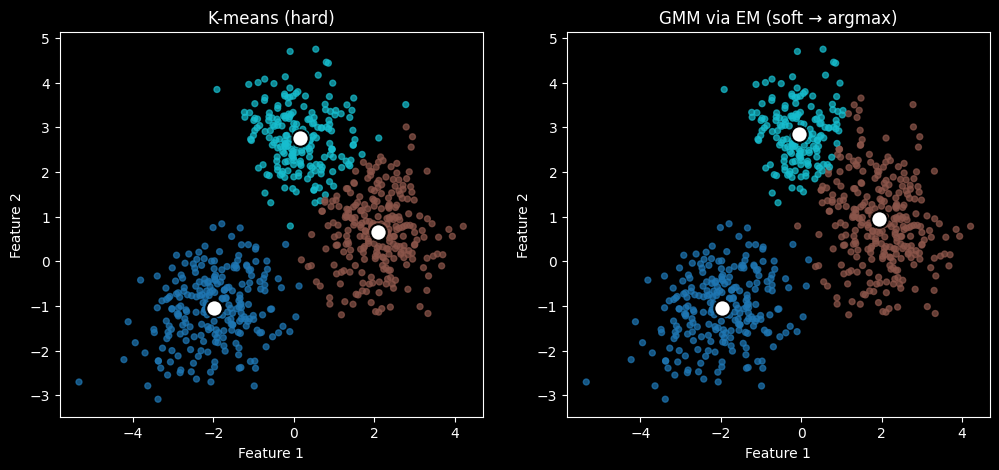

In [7]:

fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].scatter(X[:,0], X[:,1], c=labels_km, cmap="tab10", alpha=0.7, s=18)
ax[0].scatter(C[:,0], C[:,1], color="white", s=140, edgecolors="black", linewidths=1.5)
ax[0].set_title("K-means (hard)")
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")

ax[1].scatter(X[:,0], X[:,1], c=labels_em, cmap="tab10", alpha=0.7, s=18)
ax[1].scatter(mus_hat[:,0], mus_hat[:,1], color="white", s=140, edgecolors="black", linewidths=1.5)
ax[1].set_title("GMM via EM (soft → argmax)")
ax[1].set_xlabel("Feature 1")
ax[1].set_ylabel("Feature 2")

plt.show()



## Key Takeaways (Lesson 14)

### When to use K-means
- You want a fast baseline for clustering.
- You believe clusters are roughly **spherical** and similar size.
- You only need **hard assignments** (each point belongs to one cluster).
- Objective is minimizing within-cluster squared distance.

### When to use GMM + EM
- Clusters may be **elliptical**, have different orientations, or different variances.
- You want **soft assignments** (probabilities of membership).
- You want a principled likelihood objective (maximize mixture log-likelihood).

### What EM is doing
- EM alternates between:
  - **E-step:** compute responsibilities \(r_{ij}\) using current parameters
  - **M-step:** update parameters using those responsibilities
- Each EM iteration **does not decrease** the log-likelihood (you should see it increase).

### Debugging EM in practice
- If EM gets stuck in a bad solution:
  - re-run with different random seeds
  - initialize means from K-means centroids
  - add small diagonal “jitter” to covariances for stability
- If a component collapses (variance → 0):
  - clamp covariance with a minimum epsilon
  - reduce K or add regularization

### The intuition that helps everything click
- **K-means = hard clustering**
- **GMM/EM = soft clustering**
- The responsibilities are the “soft labels” that let the model fit **elliptical shapes** and uncertainty.
